<a href="https://colab.research.google.com/github/Dkreitzer/Text_ML_Classification_UMN/blob/master/Doc_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# references
https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52


# Imports and Installs

In [0]:



from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.tag import pos_tag
from gensim import corpora, models, similarities
from sklearn.externals import joblib
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import colorsys

import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
import sys
from operator import itemgetter
import time
from tqdm.auto import tqdm
import re

from datetime import datetime
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from IPython.display import display, HTML

import numpy as np  ##20.2
import pandas as pd
import matplotlib
from pathlib import Path

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Downloading Files


In [0]:
!git clone https://github.com/Dkreitzer/Text_ML_Classification_UMN

!ls

fatal: destination path 'Text_ML_Classification_UMN' already exists and is not an empty directory.
sample_data  Text_ML_Classification_UMN



Text_ML_Classification_UMN (root) 

├── data             
 |            ├── data             
 │     ├── Text_Files_Trained          # the most recent files used to train a model  <br>
 │     ├── Text_Files_History          # copy of all txt files every processed <br>
 │     ├── Text_Temp_ColorCode  # This is the HTML file with Color Coded Text <br>
 │     └── Text_Temp_Visuals         # This is the location for saved plots <br>
├── Model # This is the location for saved Models, Vectorizers <br>
├── Master_CSV # This is the location for saved Models, Vectorizers <br>
└── README.md



In [0]:
def make_pipeline(NUMBER_OF_DOCS):
    doclist = []
    names = []
    # %cd "
    pathlist = Path(
        "Text_ML_Classification_UMN/Data/Text_Files_Trained").glob('**/*.txt')

    for path in tqdm(pathlist):
        path_in_str = str(path)
    #     print(path_in_str)
        name = path_in_str.split(".")[0].split("/")[3]
        names.append(name.replace("_", " "))
        # TODO SPLIT PATH TO COMPANY NAME, make Index
        file = open(path, "r", encoding= 'Windows-1252')
        # print "Output of Readlines after appending"
        text = file.readlines()
    #     print(text[:10])
        doclist.append(text[0])
      
      
            
    df_to_split = pd.DataFrame(list(zip(names, doclist)),
                               columns=['Company', 'Text'])
    split_df = df_to_split.sample(n=NUMBER_OF_DOCS, random_state=42)
    doclist, names =  split_df["Text"].tolist(), split_df["Company"].tolist()
    print(split_df.head())
    
    
    
    return doclist, names


In [0]:
doclist, names = make_pipeline(2)


                 Company                                               Text
2115     PriceSmart Inc   [1] "Item 1A. Risk Factors. In evaluating the ...
457   ACI Worldwide Inc   [1] "ITEM 1A. RISK FACTORS. Factors That May A...


# Vectorization
In order to run the model, we need to turn words in to numbers <br>
First, we turn each document into Sentences or tokens <a href="#Token">Tokenization</a>  <br>
To remove digits, useless words and characters we use a  <a href="#Filter">Filter</a>   <br>
Finally, we <a href="#Stem">Stem</a>   each token into its word root <br>
Then we can use some sort of <a href="#Vector">Vectorizer</a> to generate our input!


<a id='Token'></a>

<h4>Tokenization</h4>

In [0]:
def transform_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing", leave=True, position=0):
        dirty_tokens = nltk.sent_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list

In [0]:
tokens = transform_tokens(doclist)
tokens[0][:5]

['[1] "Item 1A.',
 'Risk Factors.',
 "In evaluating the Company's business, you should consider the following discussion of risk factors, in addition to other information contained in this report and in the Company's other public filings with the U.S. Securities and Exchange Commission.",
 'Any such risks could materially and adversely affect our business, financial condition, results of operations, cash flow and prospects.',
 'However, the risks described below or incorporated by reference herein are not the only risks facing us.']

<h4>Filtering Tokens </h4>
This filters out Digits and 
<a id='Filter'></a>


In [0]:
import string
def transform_filtered(token_list, doclist, names):

    punc = ['.', ',', '"', "'", '?', '!', ':',
            ';', '(', ')', '[', ']', '{', '}', "%"]
    more_stops = ['\t',
                  '\\t\\t\\', '\\t\\t\\t',
                  '<U+25CF>', '<u+feff>',  '[1]', 'feff', '1a', 'item']
    maybe_bad_stops = ['may', 'could',  'contents',
                       'table', 'time', '25cf', 'factors', 'risk']
    stopwords_list = stopwords.words(
        'english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    names_list = []
    
    #WE CAN RUN 1 or many docs at once#
    if type(token_list) != list:
        token_list = [token_list]
    index = 0
              

    for document in tqdm(token_list, desc="Filtering Documents"):
        name = names[index]
        for token in document:
            filtered_token = [word.lower() for word in token.split(" ") if word.lower() not in stopwords_list and word.isalpha()]
#             print(filtered_token)
#             for word in token.split(" "):
#                 word=word.lower()
#                 if re.search(r'\d{1,}', word) or word in stopwords_list:  # getting rid of digits
#                     pass
#                 else:
#                     filtered_token.append(word)
# #                               
            filtered_token = ' '.join(filtered_token)
            if len(filtered_token) != 0:
                names_list.append(name)
                filtered_tokens.append(filtered_token)
        index += 1
    
    return filtered_tokens, names_list, stopwords_list

In [0]:
filtered_tokens, names_list, stopwords_list = transform_filtered(tokens, doclist, names)
filtered_tokens[:10]

['evaluating consider following discussion addition information contained report public filings securities exchange',
 'risks materially adversely affect financial results cash flow',
 'risks described incorporated reference herein risks facing',
 'additional risks uncertainties currently known us currently view immaterial also materially adversely affect financial results cash flow',
 'financial performance dependent international exposes us various',
 'international operations account nearly total',
 'financial performance subject risks inherent operating expanding international membership warehouse club',
 'inconsistent enforcement laws including related tariffs',
 'imposition foreign domestic governmental including expropriation',
 'including quotas general restrictions']

In [0]:
"risk" in filtered_tokens

False

<h4>Stemming!</h4>
<a id='Stem'></a>


In [0]:
def transform_stemming(filtered_tokens):
    stemmed = []
    for token in tqdm(filtered_tokens, desc="Stemming"):
        sentence = []
        stemmed_token = [PorterStemmer().stem(word) for word in token.split(" ")]
        stemmed_token = [word for word in stemmed_token if word not in stopwords_list]
#         stemmed_token = [LancasterStemmer().stem(word) for word in token.split(" ")]
#         stemmed_token = [SnowballStemmer('english').stem(word) for word in token.split(" ")]

        stemmed_token = ' '.join(stemmed_token)
        stemmed.append(stemmed_token)

    return stemmed

In [0]:
stemmed = transform_stemming(filtered_tokens)
stemmed[:5]

['evalu consid follow discuss addit inform contain report public file secur exchang',
 'materi advers affect financi result cash flow',
 'describ incorpor refer herein face',
 'addit uncertainti current known us current view immateri also materi advers affect financi result cash flow',
 'financi perform depend intern expos us variou']

In [0]:
stemmed

['evalu consid follow discuss addit inform contain report public file secur exchang',
 'materi advers affect financi result cash flow',
 'describ incorpor refer herein face',
 'addit uncertainti current known us current view immateri also materi advers affect financi result cash flow',
 'financi perform depend intern expos us variou',
 'intern oper account nearli total',
 'financi perform subject inher oper expand intern membership warehous club',
 'inconsist enforc law includ relat tariff',
 'imposit foreign domest government includ expropri',
 'includ quota gener restrict',
 'foreign',
 'cost associ intern sale administr intern merchandis',
 'secur advers affect economi countri oper requir us incur addit cost provid addit secur warehous',
 'permit regulatori',
 'foreign currenc exchang',
 'polit well econom busi',
 'suppli',
 'circumst relat result disrupt bank merchandis currenc exchang materi advers effect busi result',
 'failur us manag wide dispers oper advers affect',
 'august c

<h4>TF_IDF Vectorizor</h4>
<a id='Vector'></a>


In [0]:
def transform_vectorize(stemmed, smallest_ngram, largest_ngram):

    vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                 ngram_range=(smallest_ngram, largest_ngram), max_df=0.55, min_df=0.01)
#     vectorizer = CountVectorizer(stop_words=stopwords_list,
#                                  ngram_range=(smallest_ngram, largest_ngram), max_df=0.75, min_df=0.01)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    return sparseMatrix, vectorizer

In [0]:
smallest_ngram = 1
largest_ngram = len(max(tokens, key=len))
%time sparseMatrix, vectorizer = transform_vectorize(stemmed, smallest_ngram, largest_ngram)

CPU times: user 219 ms, sys: 9.98 ms, total: 229 ms
Wall time: 233 ms


In [0]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.55, max_features=None, min_df=0.01,
        ngram_range=(1, 249), norm='l2', preprocessor=None,
        smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...)', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', '25cf', 'factors', 'risk'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
import operator

least_used = dict(sorted(vectorizer.vocabulary_.items(),
            key=operator.itemgetter(1), reverse=False)[:5])
most_used = dict(sorted(vectorizer.vocabulary_.items(),
            key=operator.itemgetter(1), reverse=True)[:5])
print("Most Common Words", most_used)
print("Least Common Words", least_used)

Most Common Words {'would': 374, 'work': 373, 'without': 372, 'within': 371, 'whether': 370}
Least Common Words {'abil': 0, 'abl': 1, 'accept': 2, 'access': 3, 'account': 4}


In [0]:
import matplotlib.pyplot as plt


def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [0]:
sparseMatrix

<419x375 sparse matrix of type '<class 'numpy.float64'>'
	with 4842 stored elements in Compressed Sparse Row format>

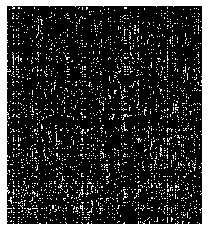

In [0]:
plot_coo_matrix(sparseMatrix).figure.show()

THIS IS WHERE WE WILL HAVE AN EXAMPLE SPARSE MATRIX 

# Model Training

In [0]:
# from sklearn.model_selection import GridSearchCV
# model = KMeans(init='k-means++', random_state=42, n_init=15
#                    )
# param_grid = {'max_iter': [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 1000],
#              'n_clusters': [25,30, 33, 35],
#              }
# grid = GridSearchCV(model, param_grid, verbose=3, n_jobs=8)
# grid.fit(sparseMatrix)

# lids = model.cluster_centers_

# score = model.score(sparseMatrix)
# silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')

Fitting 3 folds for each of 44 candidates, totalling 132 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   22.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed:  2.0min finished


AttributeError: ignored

In [0]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'max_iter': 10, 'n_clusters': 25}
-133.69029847271176


<h3>KMEANS</h3>![Kmean Model Example](https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif)

In [0]:
def estimator_cluster(sparseMatrix, vectorizer):
    truek = 35  # FROM GRID SEARCH
    model = KMeans(n_clusters=truek, init='k-means++',
                   max_iter=50, n_init=1, random_state=42,
                   )
    model.fit(sparseMatrix)

    model_time = datetime.now().strftime("%b%d-%I%M%p")
    joblib.dump(model,  f'Text_ML_Classification_UMN/Model/model{model_time}.pkl')
    joblib.dump(vectorizer,  f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    return terms, order_centroids, model, truek, model_time

In [0]:
# THIS TAKES ~~ 1m per 100 documents
%time terms, order_centroids, model, truek, model_time = estimator_cluster(sparseMatrix, vectorizer)

CPU times: user 491 ms, sys: 131 ms, total: 622 ms
Wall time: 493 ms


In [0]:
def estimator_ppscore(model):
    labels = model.labels_
    centroids = model.cluster_centers_

    print(f"Model Generated at {model_time}")

    print("Cluster id labels for inputted data")
    print(labels)
    print("Centroids data")
    #print (centroids)

    kmeans_score = model.score(sparseMatrix)
    print("Score (Opposite of the value of X on the K-means objective, \n",
          "which is Sum of distances of samples to their closest cluster center):")
    print(kmeans_score)

    silhouette_score = metrics.silhouette_score(
        sparseMatrix, labels, metric='euclidean')

    print("Silhouette_score: ")
    print(silhouette_score)
    return kmeans_score, silhouette_score


In [0]:
#@title Saved Models { display-mode: "form" }

pathlist = Path(
        "Text_ML_Classification_UMN/Model/").glob('**/*.pkl')
# times = []

times = set([str(path).split(".pkl")[0].split("/")[2].replace(
        "model", "").replace("vec", "") for path in pathlist])
print('Saved Models:', times)


Saved Models: {'Feb14-0130PM', 'Mar19-0425AM', 'Mar19-0355AM', 'Mar19-0319AM'}


In [0]:
#@title Select a Model { run: "auto", display-mode: "both" }
# using joblib to pickle model

def estimator_load_model(model_time):
      
      vectorizer = joblib.load(f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
      model = joblib.load(f'Text_ML_Classification_UMN/Model/model{model_time}.pkl')
      estimator_ppscore(model)
      return model, vectorizer
# content/Text_ML_Classification_UMN/Model/vec.pkl
# content/Text_ML_Classification_UMN/Model/modelFeb14-0130PM.pkl

# TODO IMPORTANT RETURN VECTORIZER
model_time ='Mar19-0355AM' #@param {type:"string"}
model, vectorizer = estimator_load_model(model_time)

Model Generated at Mar19-0355AM
Cluster id labels for inputted data
[10 31 32 31  4 33  2  8 17  7 24 15 10 17 24 29 17 15  0 20  5 10 25  3
 32  2 13 32 32 26 20 20 32 22 26 26 20 20 10 20 18  2  9 20 20 20 20 33
  9 20 13 13 20 25 25 14 25 30 15 18 21 21 21  5 26  9 21 21  5 25  9 31
  4 18  2  9  9 31 22 20 15 22 19 15  8 17 30 22 22 30 15 17  2 20 20 20
  0  3 29  0 10  2  0 31 25  2 26 17 15 22 22 14 14 14 14 14 14 23 30  2
  3  0 20 15 15 29 17  4 12 12  9  3 12 12 12 31 12 12 12 12 12 19 26 34
  3 20 24 33 20  9 10 24 24 30 30 30  9 30 23 33 32  8  8  3  8 26  8 31
  5  5 33  5  5 15  5  5 31  5 33 11 19  5 33  5  2 33 10 11 11 21  5 11
 11 11 11  5 11 11 31 11  6  6 11  6  6 22 17  6 31 15 18 18  3 18 27 27
  6 27  4 29 17 13 29 29 33 27 17 18 29 18 32 13 13 29 26 13  1 14  1  1
 28 28 28 28 28 28 23 28 27 28  5  8 18 17  7 17 31  4  4  4  4  4  4  4
  4  1 17 19 26  6 14 17  3  1  8  8  6 10  6  2  0 10 17  2  3 17 17  8
 31 11  5 11  1 17  5  5 34 26  8 31 23 23 23  8 23  1 2

In [0]:

#  https://stackoverflow.com/questions/876853/generating-color-ranges-in-python


def get_N_HexCol(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

nclosest_words_to_show = 6
colormap = get_N_HexCol(truek)



for label in range(truek):
    nclosest_words = []
    for ind in order_centroids[label, :nclosest_words_to_show]:
        nclosest_words.append(terms[ind])
    color = colormap[label]
    display(HTML(f'<font color="{color}">Cluster {label}</font>'))
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))


In [0]:
def estimator_predict_string(string):
    empty_list = ["string"]
    print('Input String: %s' % string)
    print('\n')
    print('Prediction:')
    tokens = transform_tokens(empty_list)
    filtered_tokens, names_list, stopwords_list = transform_filtered(tokens, empty_list, empty_list)
    stemmed = transform_stemming(filtered_tokens)

    
    
    
    
    X = vectorizer.transform(stemmed)
    predicted = model.predict(X)
    print('kmeans prediction: %s' % predicted)
    print("closest cluster centers :")
    for ind in order_centroids[predicted[0], :5]:
        print(' %s' % terms[ind])
    return X

In [0]:
estimator_predict_string('The hackers stole all our bitcoin!')

Input String: The hackers stole all our bitcoin!


Prediction:



kmeans prediction: [17]
closest cluster centers :
 compli
 custom
 contract
 data
 fail compli


<1x375 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [0]:
terms[:10]

['abil',
 'abl',
 'accept',
 'access',
 'account',
 'accur',
 'acquir',
 'acquisit',
 'actual',
 'addit']

In [0]:
# SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
    'Topic 0: investment, property, distribution, interest, agreement',
    'Topic 1: regulation, change, law, financial, operation, tax, accounting ',
    'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
    'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ',
    'Topic 4: cost, regulation, environmental, law, operation, liability',
    'Topic 5: control, financial, internal, loss, reporting, history ',
    'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit'
    'Topic 7: competitive, industry, competition, highly',
    'Topic 8: cost, operation, labor, operating, employee, increase, acquisition ',
    'Topic 9: product, candidate, development, approval, clinical, regulatory',
    'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible ',
    'Topic 11: interest, director, officer, trust, combination, share, conflict ',
    'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products',
    'Topic 13: loan, real, estate, investment, property, market, loss, portfolio ',
    'Topic 14: personnel, key, retain, attract, management, employee ',
    'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile  ',
    'Topic 16: acquisition, growth, future, operation, additional, capital, strategy ',
    'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks ',
    'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations'
    'Topic 19: cost, contract, operation, plan, increase, pension, delay',
    'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers',
    'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm',
    'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results',
    'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw',
    'Topic 24: regulation, government, change, revenue, contract, law, service',
    'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade ',
    'Topic 26: debt, indebtedness, cash, obligation, financial, credit, ',
    'Topic 27: operation, international, foreign, currency, rate, fluctuation',
    'Topic 28: loss, insurance, financial, loan, reserve, operation, cover',
    'Topic 29: operation, natural, facility, disaster, event, terrorist, weather ']
topics = [topic.split(":")[1] for topic in strings]

In [0]:
targets = {
    "Shareholder’s interest risk": topics[0],
    "Regulation changes(accounting)": topics[1],
    "Stakeholder’s profit": topics[2],
    "Regulation changes(environment)": topics[3],
    "Legal Risks": topics[4],
    "Financial condition risks ": topics[5],
    " Potential/Ongoing Lawsuits": topics[6],
    "market Competition risks": topics[7],
    "**Labor cost ": topics[8],
    " New product introduction risks ": topics[9],
    "**Accounting,  +Restructuring risks ": topics[10],
    "**Management": topics[11],
    " Potential defects in products": topics[12],
    "**Investment": topics[13],
    "Human resource risks": topics[13],
    "Volatile stock price risks": topics[14],
    "Merger & Acquisition risks": topics[15],
    " +Industry is cyclical": topics[16],
    " **Postpone ":  topics[17],
    " +Infrastructure risks": topics[18],
    "+Suppliers risks +Downstream risks": topics[19],
    "license Intellectual property risks": topics[20],
    "+Licensing related risks' ": topics[21],
    "+ Competition risks ": topics[22],
    "*Potential/Ongoing Lawsuits*": topics[23],
    "Regulation changes": topics[24],
    "Credit risks": topics[25],
    "covenant Funding risks ": topics[26],
    "International risks": topics[27],
    #     "Insurance" : topics[28],
    #     "Catastrophes" : topics[29]
}

In [0]:
for topic in topics:
    print(topic)
    estimator_predict_string(topic)

 investment, property, distribution, interest, agreement
Input String:  investment, property, distribution, interest, agreement


Prediction:
kmeans prediction: [34]
closest cluster centers :
 agreement
 transit
 asset
 certain
 connect
 regulation, change, law, financial, operation, tax, accounting 
Input String:  regulation, change, law, financial, operation, tax, accounting 


Prediction:
kmeans prediction: [12]
closest cluster centers :
 tax
 interpret
 author
 subject
 believ
 gas, price, oil, natural, operation, production Input prices risks 
Input String:  gas, price, oil, natural, operation, production Input prices risks 


Prediction:
kmeans prediction: [29]
closest cluster centers :
 price
 common
 market
 econom
 well
 stock, price, share, market, future, dividend, security, stakeholder 
Input String:  stock, price, share, market, future, dividend, security, stakeholder 


Prediction:
kmeans prediction: [29]
closest cluster centers :
 price
 common
 market
 econom
 well
 cos

In [0]:
doclist, names = make_pipeline(15)


                          Company  \
2115              PriceSmart Inc    
457            ACI Worldwide Inc    
1820  Cheniere Energy Partners LP   
2413      Encore Wire Corporation   
564         Align Technology Inc    

                                                   Text  
2115  [1] "Item 1A. Risk Factors. In evaluating the ...  
457   [1] "ITEM 1A. RISK FACTORS. Factors That May A...  
1820  [1] "ITEM 1A. RISK FACTORS. Limited partner in...  
2413  [1] "Item 1A. Risk Factors.. The following are...  
564   [1] "ITEM 1A.RISK FACTORS. We depend on the sa...  


In [0]:
def estimator_predict_document(document, name):
    dictionary_list = []
    for counter, sentence in enumerate(document.split(".")):
        if len(sentence) != 0:
            vector_matrix = vectorizer.transform([sentence])
            predicted_label = model.predict(vector_matrix)
            sentence_len = len(sentence.split(" "))
            sentence_info = {'company': name, 'sentence#': counter, 'text': sentence,
                             'wordcount': sentence_len, 'label': predicted_label[0]}
            dictionary_list.append(sentence_info)
    dataframe = pd.DataFrame(dictionary_list)
    dataframe["% of total"] = dataframe['wordcount'] / \
        sum(dataframe['wordcount'])
#         (name, sentence, predicted_label)
    return(dataframe)

In [0]:
frames = []
for document, name in zip(doclist, names):
    frame = estimator_predict_document(document, name)
    frames.append(frame)

muliple_company_frame = pd.concat(frames)
muliple_company_frame.head()

,company,label,sentence#,text,wordcount,% of total
0,PriceSmart Inc,17,0,"[1] ""Item 1A",3,0.000439
1,PriceSmart Inc,17,1,Risk Factors,3,0.000439
2,PriceSmart Inc,17,2,"In evaluating the Company's business, you sho...",34,0.004974
3,PriceSmart Inc,17,3,S,1,0.000146
4,PriceSmart Inc,17,4,Securities and Exchange Commission,5,0.000731


In [0]:
grouped_frame = muliple_company_frame.groupby(
    ['company', 'label']).agg({'% of total': 'sum'}).reset_index()
grouped_frame.head()

,company,label,% of total
0,ACI Worldwide Inc,0,0.039493
1,ACI Worldwide Inc,1,0.018888
2,ACI Worldwide Inc,2,0.004623
3,ACI Worldwide Inc,4,0.042795
4,ACI Worldwide Inc,5,0.019284


In [0]:
def prep_for_heatmap(muliple_company_frame):
    company_clusters = muliple_company_frame.groupby(['label', 'company']).agg(
        {'% of total': 'sum'}).unstack(level='company').fillna(0).T

    company_clusters = company_clusters.reset_index(level=0, drop=True)
    return company_clusters


company_clusters = prep_for_heatmap(muliple_company_frame)
company_clusters.head()

label,0,1,2,4,5,6,7,8,9,10,...,24,25,26,27,29,30,31,32,33,34
company,,,,,,,,,,,,,,,,,,,,,
ACI Worldwide Inc,0.039493,0.018888,0.004623,0.042795,0.019284,0.032096,0.023379,0.006604,0.007132,0.013472,...,0.023379,0.013208,0.048210,0.020605,0.028530,0.000000,0.015982,0.015190,0.000000,0.017699
Achieve Life Sciences Inc,0.064557,0.011050,0.004536,0.022392,0.000000,0.017390,0.002734,0.029196,0.027626,0.007852,...,0.010062,0.008840,0.017099,0.005700,0.064034,0.000000,0.011516,0.010527,0.000000,0.023380
Align Technology Inc,0.026165,0.000000,0.007769,0.034113,0.038578,0.042597,0.004197,0.006608,0.042865,0.007055,...,0.010091,0.016521,0.044919,0.005179,0.078318,0.014110,0.020897,0.013663,0.001072,0.009109
Barings BDC Inc,0.052103,0.006344,0.014300,0.020800,0.026624,0.045759,0.001092,0.004680,0.031356,0.007592,...,0.001456,0.012896,0.074359,0.008840,0.145182,0.002132,0.021216,0.007904,0.003484,0.026468
Cheniere Energy Partners LP,0.057416,0.085732,0.018930,0.077806,0.007144,0.029568,0.004537,0.016896,0.006571,0.006258,...,0.000000,0.008761,0.042397,0.018356,0.133239,0.015019,0.006675,0.005841,0.002972,0.048290


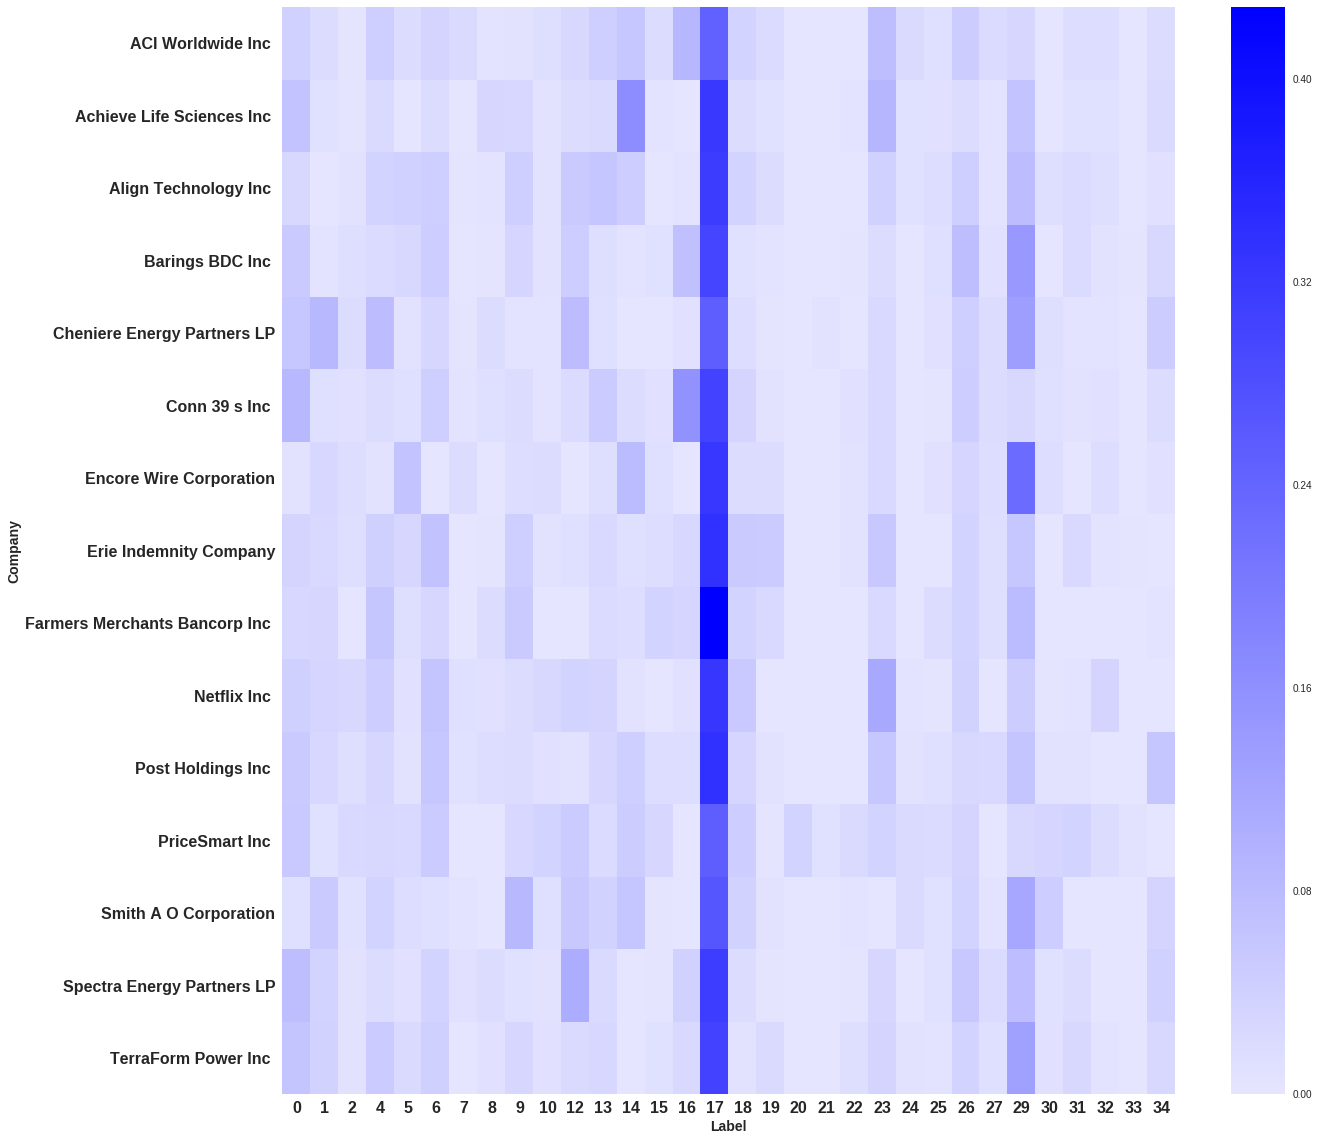

In [0]:
def plot_heatmap(company_clusters):
    fig2, ax2 = plt.subplots(figsize=(20, 20))
    cmap = sns.light_palette('blue', as_cmap=True)

    sns.heatmap(company_clusters, ax=ax2, cmap=cmap)

    ax2.set_xlabel('Label', fontdict={'weight': 'bold', 'size': 14})
    ax2.set_ylabel('Company', fontdict={'weight': 'bold', 'size': 14})
    for label in ax2.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")
    plt.savefig("Text_ML_Classification_UMN/Data/Text_Temp_ColorCode/Heatmap.jpg", dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)


plot_heatmap(company_clusters)

In [0]:
company_clusters.T.head(35)

company,ACI Worldwide Inc,Achieve Life Sciences Inc,Align Technology Inc,Barings BDC Inc,Cheniere Energy Partners LP,Conn 39 s Inc,Encore Wire Corporation,Erie Indemnity Company,Farmers Merchants Bancorp Inc,Netflix Inc,Post Holdings Inc,PriceSmart Inc,Smith A O Corporation,Spectra Energy Partners LP,TerraForm Power Inc
label,,,,,,,,,,,,,,,
0,0.039493,0.064557,0.026165,0.052103,0.057416,0.084721,0.008068,0.032307,0.028195,0.040796,0.052169,0.053540,0.013119,0.073881,0.062946
1,0.018888,0.011050,0.000000,0.006344,0.085732,0.013310,0.027342,0.023565,0.028808,0.030956,0.028179,0.011118,0.053465,0.035181,0.037333
2,0.004623,0.004536,0.007769,0.014300,0.018930,0.009299,0.015240,0.015013,0.000000,0.025318,0.014788,0.024722,0.011139,0.007461,0.007703
4,0.042795,0.022392,0.034113,0.020800,0.077806,0.019144,0.007620,0.041239,0.058535,0.045661,0.029905,0.025892,0.033663,0.017045,0.048580
5,0.019284,0.000000,0.038578,0.026624,0.007144,0.012520,0.064545,0.028696,0.015017,0.008513,0.007230,0.023991,0.016337,0.009766,0.023061
6,0.032096,0.017390,0.042597,0.045759,0.029568,0.043758,0.000000,0.067465,0.029421,0.061913,0.058002,0.050029,0.013119,0.035424,0.040499
7,0.023379,0.002734,0.004197,0.001092,0.004537,0.005287,0.018377,0.000950,0.000000,0.012604,0.011255,0.000000,0.005941,0.008917,0.003072
8,0.006604,0.029196,0.006608,0.004680,0.016896,0.013188,0.000000,0.004751,0.016856,0.009287,0.015938,0.000000,0.000000,0.017348,0.009546
9,0.007132,0.027626,0.042865,0.031356,0.006571,0.017443,0.016136,0.044470,0.052712,0.018684,0.018732,0.027794,0.086634,0.011161,0.029677


NameError: ignored

In [0]:
# coloring txt file
doc_index = 0
company = muliple_company_frame['company'].unique()[doc_index]
companyFrame = muliple_company_frame[muliple_company_frame['company'] == company]
for text, label in zip(companyFrame['text'], companyFrame['label']):
    color = colormap[label]
    display(HTML(f'<font color="{color}">' +
                     text + f'  ({label})' + '</font>'))

In [0]:
# global bad_labels
# bad_labels = []
# def mean_supercluster(dataframe):
#     for index, value in zip(dataframe.mean(axis=0).index, dataframe.mean(axis=0)):
#         if value > .75:
#             if index not in bad_labels:
#                 bad_labels.append(index)
#             return index, value

# supercluster_label, value = mean_supercluster(prep_for_heatmap(muliple_company_frame))
# print(supercluster_label, value)
# print(bad_labels)
# while type(supercluster_label) == int and len(bad_labels) < truek:

#     to_recluster = muliple_company_frame['label']==supercluster_label
#     recluster_frame = muliple_company_frame[to_recluster]
#     index_values = recluster_frame['text'].index.values
#     texts = recluster_frame['text'].values
#     for index_value, text in zip(index_values, texts):
#         X = vectorizer.transform([text])
#         distances = euclidean_distances(X, model.cluster_centers_)
#         for label in bad_labels:
#             distances[0][label] = 99
#         min_value = min(distances[0])
#         new_mins = [i for i, x in enumerate(distances[0]) if x == min_value]

#         new_min = new_mins[0]
#         muliple_company_frame.at[index_value, 'label'] = new_min

#     supercluster_label, value = mean_supercluster(prep_for_heatmap(muliple_company_frame))
#     print(supercluster_label, value)
#     print(bad_labels)
#     if value < 90:
#         plot_heatmap(prep_for_heatmap(muliple_company_frame))

<IPython.core.display.Math object>